## 读取数据

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.metrics import roc_auc_score

import lightgbm as lgb

In [2]:
trainData = pd.read_csv('./data/train_set.csv')
testData  = pd.read_csv('./data/test_set.csv')
trainDataLen = len(trainData)
testDataLen = len(testData)
allData = pd.concat([trainData, testData], sort = False)

In [3]:
# 查看数据信息
allData.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,43,management,married,tertiary,no,291,yes,no,unknown,9,may,150,2,-1,0,unknown,0.0
1,2,42,technician,divorced,primary,no,5076,yes,no,cellular,7,apr,99,1,251,2,other,0.0
2,3,47,admin.,married,secondary,no,104,yes,yes,cellular,14,jul,77,2,-1,0,unknown,0.0
3,4,28,management,single,secondary,no,-994,yes,yes,cellular,18,jul,174,2,-1,0,unknown,0.0
4,5,42,technician,divorced,secondary,no,2974,yes,no,unknown,21,may,187,5,-1,0,unknown,0.0


In [4]:
allData.describe()

,ID,age,balance,day,duration,campaign,pdays,previous,y
count,36169.00000,36169.000000,36169.000000,36169.000000,36169.000000,36169.000000,36169.000000,36169.000000,25317.000000
mean,18085.00000,40.966961,1368.237026,15.788742,257.574497,2.771545,40.160552,0.578147,0.116957
std,10441.23528,10.639679,3098.876172,8.314523,255.040668,3.114445,100.005886,2.365582,0.321375
min,1.00000,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,9043.00000,33.000000,73.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,18085.00000,39.000000,449.000000,16.000000,181.000000,2.000000,-1.000000,0.000000,0.000000
75%,27127.00000,48.000000,1437.000000,21.000000,318.000000,3.000000,-1.000000,0.000000,0.000000
max,36169.00000,95.000000,102127.000000,31.000000,3881.000000,58.000000,871.000000,275.000000,1.000000


In [5]:
# 查看所有object的枚举类型
# 帅选出object类型
def objectInfoView(data):
    columnObjects = data.columns[data.dtypes=="object"]
    dic = {}
    for object in columnObjects:
        dic[object] = data[object].unique()
    return dic

In [6]:
objectInfoView(allData)

{'job': array(['management', 'technician', 'admin.', 'services', 'retired',
        'student', 'blue-collar', 'unknown', 'entrepreneur', 'housemaid',
        'self-employed', 'unemployed'], dtype=object),
 'marital': array(['married', 'divorced', 'single'], dtype=object),
 'education': array(['tertiary', 'primary', 'secondary', 'unknown'], dtype=object),
 'default': array(['no', 'yes'], dtype=object),
 'housing': array(['yes', 'no'], dtype=object),
 'loan': array(['no', 'yes'], dtype=object),
 'contact': array(['unknown', 'cellular', 'telephone'], dtype=object),
 'month': array(['may', 'apr', 'jul', 'jun', 'nov', 'aug', 'jan', 'feb', 'dec',
        'oct', 'sep', 'mar'], dtype=object),
 'poutcome': array(['unknown', 'other', 'failure', 'success'], dtype=object)}

## 数据预处理

| NO |  字段名称 | 数据类型 |                             字段描述                            |
|:--:|:---------:|:--------:|:---------------------------------------------------------------:|
|  1 |     ID    |    Int   |                           客户唯一标识                          |
|  2 |    age    |    Int   |                             客户年龄                            |
|  3 |    job    |  String  |                            客户的职业                           |
|  4 |  marital  |  String  |                             婚姻状况                            |
|  5 | education |  String  |                            受教育水平                           |
|  6 |  default  |  String  |                          是否有违约记录                         |
|  7 |  balance  |    Int   |                        每年账户的平均余额                       |
|  8 |  housing  |  String  |                          是否有住房贷款                         |
|  9 |    loan   |  String  |                          是否有个人贷款                         |
| 10 |  contact  |  String  |                       与客户联系的沟通方式                      |
| 11 |    day    |    Int   |                    最后一次联系的时间（几号）                   |
| 12 |   month   |  String  |                    最后一次联系的时间（月份）                   |
| 13 |  duration |    Int   |                      最后一次联系的交流时长                     |
| 14 |  campaign |    Int   |                在本次活动中，与该客户交流过的次数               |
| 15 |   pdays   |    Int   | 距离上次活动最后一次联系该客户，过去了多久（999表示没有联系过） |
| 16 |  previous |    Int   |               在本次活动之前，与该客户交流过的次数              |
| 17 |  poutcome |  String  |                         上一次活动的结果                        |
| 18 |     y     |    Int   |                  预测客户是否会订购定期存款业务                 |

### 对文本类型数据进行编码

In [7]:
# 对文本数据进行编码
for col in allData.columns[allData.dtypes=='object']:
    le = LabelEncoder()
    le.fit(allData[col])
    
    allData[col] = le.transform(allData[col])

allData.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,43,4,1,2,0,291,1,0,2,9,8,150,2,-1,0,3,0.0
1,2,42,9,0,0,0,5076,1,0,0,7,0,99,1,251,2,1,0.0
2,3,47,0,1,1,0,104,1,1,0,14,5,77,2,-1,0,3,0.0
3,4,28,4,2,1,0,-994,1,1,0,18,5,174,2,-1,0,3,0.0
4,5,42,9,0,1,0,2974,1,0,2,21,8,187,5,-1,0,3,0.0


## 划分数据集

In [8]:
train_use_col = list(set(allData.columns)-set(['ID','y']))
X1 = allData[train_use_col][:trainDataLen]
y1 = allData['y'][:trainDataLen]

X2 = allData[train_use_col][trainDataLen:]
X1.head()

,campaign,contact,balance,month,day,housing,previous,marital,job,education,pdays,age,default,poutcome,duration,loan
0,2,2,291,8,9,1,0,1,4,2,-1,43,0,3,150,0
1,1,0,5076,0,7,1,2,0,9,0,251,42,0,1,99,0
2,2,0,104,5,14,1,0,1,0,1,-1,47,0,3,77,1
3,2,0,-994,5,18,1,0,2,4,1,-1,28,0,3,174,1
4,5,2,2974,8,21,1,0,0,9,1,-1,42,0,3,187,0


## 特征选择

In [9]:
# Univariate Selection
'''
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X1,y1)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X1.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features
'''

"\nbestfeatures = SelectKBest(score_func=chi2, k=10)\nfit = bestfeatures.fit(X1,y1)\ndfscores = pd.DataFrame(fit.scores_)\ndfcolumns = pd.DataFrame(X1.columns)\n#concat two dataframes for better visualization \nfeatureScores = pd.concat([dfcolumns,dfscores],axis=1)\nfeatureScores.columns = ['Specs','Score']  #naming the dataframe columns\nprint(featureScores.nlargest(10,'Score'))  #print 10 best features\n"

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.05874945 0.02536881 0.08864058 0.09333344 0.09272972 0.02497045
 0.03153375 0.02524713 0.05961387 0.03830077 0.03818257 0.10071124
 0.00284707 0.05740072 0.2511824  0.01118802]


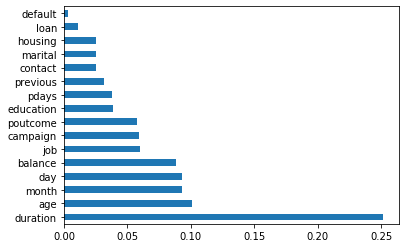

In [10]:
# Feature Importance
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X1,y1)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X1.columns)
feat_importances.nlargest(100).plot(kind='barh')
plt.show()

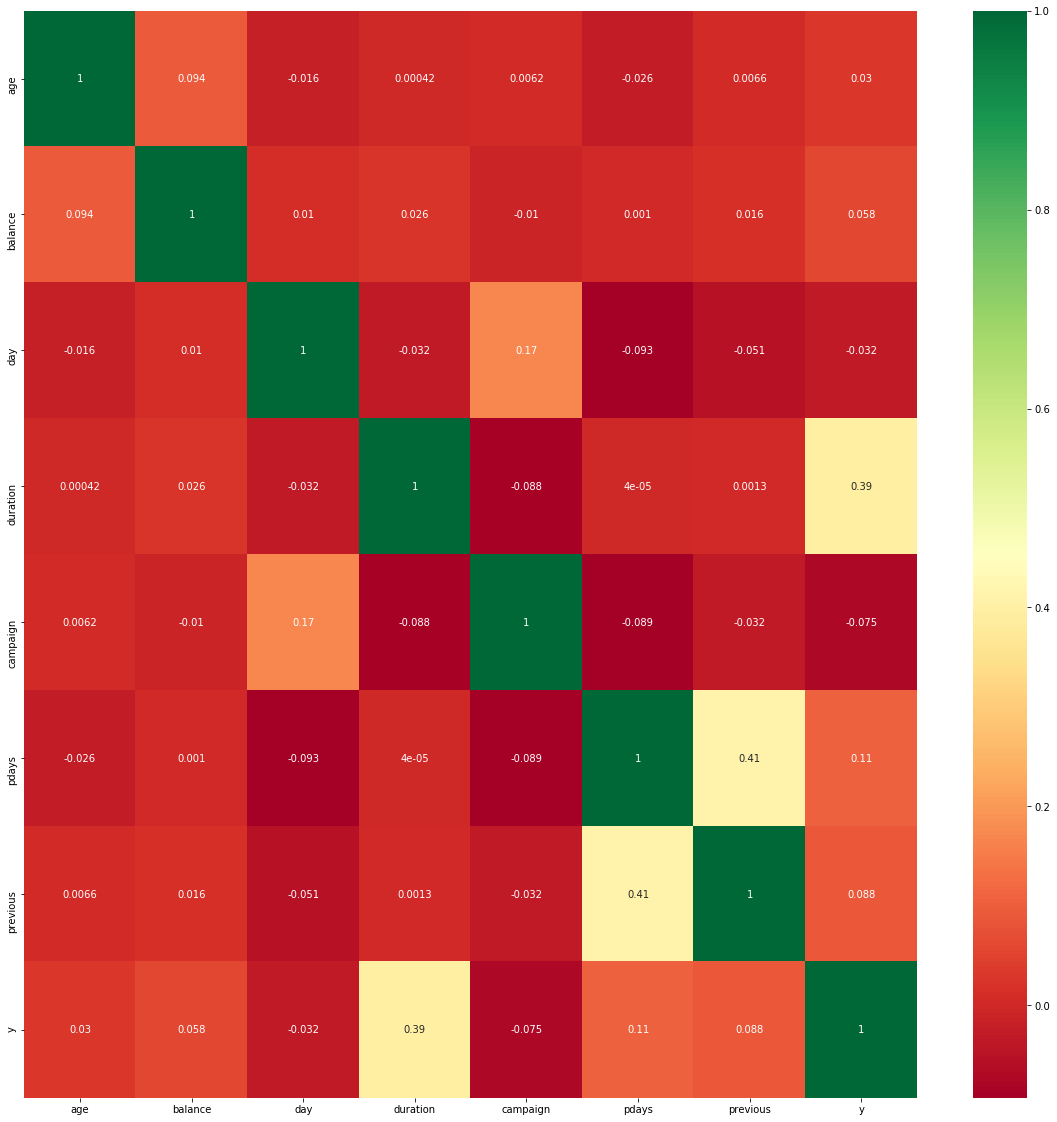

In [11]:
# Correlation Matrix with Heatmap
import seaborn as sns

corrData = trainData.drop(columns = ['ID'])
corrmat = corrData.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrData[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## 特征构建

In [12]:
import featuretools as ft
es = ft.EntitySet(id="ID")
es = es.entity_from_dataframe(entity_id ="bank", dataframe = allData,
                             index = "ID")

features, feature_names = ft.dfs(entityset = es, target_entity = 'bank', 
                                 trans_primitives = ['month', 'day'],
                                 max_depth = 2)
feature_names

[<Feature: age>,
 <Feature: job>,
 <Feature: marital>,
 <Feature: education>,
 <Feature: default>,
 <Feature: balance>,
 <Feature: housing>,
 <Feature: loan>,
 <Feature: contact>,
 <Feature: day>,
 <Feature: month>,
 <Feature: duration>,
 <Feature: campaign>,
 <Feature: pdays>,
 <Feature: previous>,
 <Feature: poutcome>,
 <Feature: y>]

## 归一化

In [13]:

numColumns = ['age','balance','duration','campaign','pdays','previous']
''''''
scaler = StandardScaler()
scaler.fit(allData[numColumns])
allData[numColumns] = scaler.transform(allData[numColumns])
allData.head()


train_use_col = list(set(allData.columns)-set(['ID','y']))
X1 = allData[train_use_col][:trainDataLen]
y1 = allData['y'][:trainDataLen]
y1_predict = oof = np.zeros(len(y1))
X2 = allData[trainDataLen:][train_use_col]


## 算法模型搭建
LightGBM

In [14]:
params = {
    'task':'train',
    'boosting_type':'gbdt',
    'objective':'binary',
    'metric':{'auc'},
    'verbose':0,
    'learning_rate':0.01,
    'is_unbalance':True
}
score = []
n_splits = 10
kfold = KFold(n_splits, shuffle=True, random_state=88)
pred = 0
i = 0
for train_idx, val_idx in kfold.split(X1):
    print("fold: ",i)
    i=i+1
    train_data = lgb.Dataset(X1.loc[train_idx], label = y1.loc[train_idx])
    val_data = lgb.Dataset(X1.loc[val_idx], label = y1.loc[val_idx])
    
    model = lgb.train(params,
                  train_data,
                  num_boost_round=1000,
                  valid_sets=[train_data,val_data],
                  early_stopping_rounds=10,
                  categorical_feature=['job','marital','education','default','housing','loan','contact','poutcome'],
                  verbose_eval = 100
                 )    
    pred += model.predict(X2[train_use_col],num_iteratio=model.best_iteration)
    
    y1_predict[val_idx] = model.predict(X1.loc[val_idx,:], num_iteration=model.best_iteration)
    
pred = pred / n_splits

print("roc_auc_score:  ",roc_auc_score(y1, y1_predict))

fold:  0


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['contact', 'default', 'education', 'housing', 'job', 'loan', 'marital', 'poutcome']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[39]	training's auc: 0.92098	valid_1's auc: 0.901982
fold:  1
Training until validation scores don't improve for 10 rounds.
[100]	training's auc: 0.928562	valid_1's auc: 0.928069
[200]	training's auc: 0.937578	valid_1's auc: 0.934569
[300]	training's auc: 0.943757	valid_1's auc: 0.937877
[400]	training's auc: 0.949068	valid_1's auc: 0.940512
Early stopping, best iteration is:
[454]	training's auc: 0.951951	valid_1's auc: 0.941116
fold:  2
Training until validation scores don't improve for 10 rounds.
[100]	training's auc: 0.930836	valid_1's auc: 0.910776
[200]	training's auc: 0.939331	valid_1's auc: 0.916229
[300]	training's auc: 0.945837	valid_1's auc: 0.92128
[400]	training's auc: 0.950871	valid_1's auc: 0.924244
Early stopping, best iteration is:
[449]	training's auc: 0.953262	valid_1's auc: 0.924935
fold:  3
Training until validation scores don't improve for 10 rounds.
[100]	training's a

## 输出比赛结果

In [15]:
resultData = pd.DataFrame(pred, index=X2['ID'], columns=['pred'])
resultData.to_csv('result.csv')